In [1]:
# 상위 폴더 경로 가져오기.
from example_base import GetParentPath
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread

In [2]:
# 1개 로봇을 연결하는 인스턴스 생성.
PingPongThreadInstance = PingPongThread(number=1, group_id=4)
# 로봇 제어 쓰레드 시작.
PingPongThreadInstance.start()
# 모든 로봇이 연결될 때 까지 기다림.
PingPongThreadInstance.wait_until_full_connect()

Found device: nRF Connect USB CDC ACM(COM12)
Serial connected.Write data: DD DD 04 DD 00 00 DA 00 0B 00 00

Connected with a master robot.
Fully connected.


In [3]:
# 큐브 ID
cube_ID = 1

In [4]:
# 웹캠 열기.
# PingPongThreadInstance.webcam_open(0)
PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

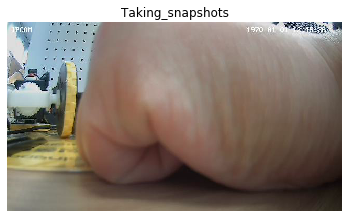

Q hit, closing...


In [5]:
# chapter9\rock 폴더 안에 '바위 사진' 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter9/rock")

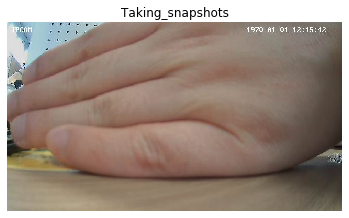

Q hit, closing...


In [6]:
# chapter9\paper 폴더 안에 '보 사진' 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter9/paper")

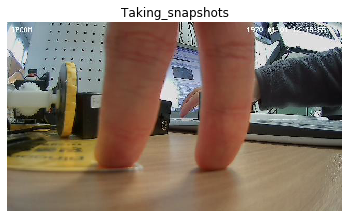

Q hit, closing...


In [7]:
# chapter9\scissors 폴더 안에 '가위 사진' 찍기.
PingPongThreadInstance.webcam_take_snapshots("chapter9/scissors")

In [8]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()

In [9]:
# '바위 사진' 클래스 인스턴스, '보' 클래스 인스턴스 생성, '가위' 클래스 인스턴스 생성.
rock = PingPongThreadInstance.ImageClass("rock", "chapter9/rock")
paper = PingPongThreadInstance.ImageClass("paper", "chapter9/paper")
scissors = PingPongThreadInstance.ImageClass("scissors", "chapter9/scissors")

In [10]:
# 모델 트레이닝. 
# 첫 번째 인수는 저장하는 이름, 두 번째 인수는 knn 알고리즘의 k 값, 세 번째 인수는 모델 모드. 네 번째 인수 이후는 클래스 인스턴스들.
model = PingPongThreadInstance.train_classes("chapter9/rps_model.json", 10, 2, rock, paper, scissors)

Class rock : 10 images.
Class paper : 10 images.
Class scissors : 10 images.
Training done.
chapter9/rps_model.json saved.


In [11]:
# 시간 제어를 위한 모듈 import.
import time
# 키보드 제어를 위한 모듈 import.
import keyboard
# 가위바위보 무작위 선택을 위한 모듈 import.
import random

print("스페이스 키를 누르면 가위바위보 게임을 시작합니다!")
time.sleep(4)
# 스페이스 바 키를 누르면 루프에서 나감.
while True:
    if keyboard.is_pressed(" "):
        break
    else:
        time.sleep(0.1)

print("가위바위보!")

스페이스 키를 누르면 가위바위보 게임을 시작합니다!
가위바위보!


In [12]:
# 웹캠 열기.
# PingPongThreadInstance.webcam_open(0)
PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

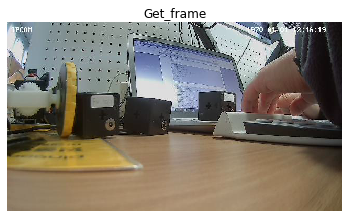

{'rock': 0, 'paper': 0, 'scissors': 10}
accum_prediction: {'scissors': 1.0}
인식된 손 모양: scissors
Write data: FF FF 04 00 10 00 C1 00 13 02 01 00 02 03 84 00 00 01 4D
바위!
이겼다~!


In [13]:
# 시간 제어를 위한 모듈 import.
import time
# 키보드 제어를 위한 모듈 import.
import keyboard
# 가위바위보 무작위 선택을 위한 모듈 import.
import random

# x는 로봇이 낸 손. 0, 1, 2 중 무작위로 하나를 고름. 0이면 바위, 1이면 가위, 2이면 보.
x = random.randint(0, 2)
# 로봇이 돌려야 할 각도 가져오기.
angle = [60/360, 180/360, 240/360][x]

# 프레임을 평가하는 인스턴스 생성. 누적 프레임은 3초 동안 보관.
frames_predictor = PingPongThreadInstance.FramesPredictor(model=model, timer_sec=3)
while True:
    # 주피터 노트북 출력 비우기.
    PingPongThreadInstance.clear_output()
    # 현재 웹캠 프레임을 보여주고 가져오기.
    frame = PingPongThreadInstance.webcam_get_frame(window="Get_frame")
    # 현재 프레임을 평가하고, 평가 내용을 누적.
    frames_prediction = frames_predictor.image_predict_and_accum(frame)
    print(frames_prediction)
    # 누적된 평가 내용.
    accum_prediction = frames_predictor.accum_predict()
    # 누적된 평가 내용이 없으면 돌아가기. 아니면 가장 확률이 높은 클래스 확인.
    if accum_prediction == None:
        max_class = None
        continue
    else:
        print("accum_prediction:", accum_prediction)
        # 가장 확률이 높은 클래스.
        max_class = max(accum_prediction, key=accum_prediction.get)
    # 바위일 확률이 90% 이상이면 승패 계산.
    if max_class == "rock" and accum_prediction[max_class] > 0.9:
        print("인식된 손 모양:", max_class)
        # 로봇이 낸 손 쪽으로 모터를 돌림.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, angle)
        time.sleep(angle/15*60)
        if x == 0:
            print("바위!")
            print("비겼다...")
        elif x == 1:
            print("가위!")
            print("졌다 ㅠㅠ")
        else:
            print("보!")
            print("이겼다~!")
        break
    # 보일 확률이 90% 이상이면 승패 계산.
    elif max_class == "paper" and accum_prediction[max_class] > 0.9:
        print("인식된 손 모양:", max_class)
        # 로봇이 낸 손 쪽으로 모터를 돌림.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, angle)
        time.sleep(angle/15*60)
        if x == 0:
            print("바위!")
            print("졌다 ㅠㅠ")
        elif x == 1:
            print("가위!")
            print("이겼다~!")
        else:
            print("보!")
            print("비겼다...")
        break
    # 가위일 확률이 90% 이상이면 승패 계산.
    elif max_class == "scissors" and accum_prediction[max_class] > 0.9:
        print("인식된 손 모양:", max_class)
        # 로봇이 낸 손 쪽으로 모터를 돌림.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, angle)
        time.sleep(angle/15*60)
        if x == 0:
            print("바위!")
            print("이겼다~!")
        elif x == 1:
            print("가위!")
            print("비겼다...")
        else:
            print("보!")
            print("졌다 ㅠㅠ")
        break
    # 모두 아니면 돌아가기.
    else:
        continue

In [14]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()
# 로봇 제어 쓰레드 종료.
PingPongThreadInstance.end()

Write data: FF FF FF FF 00 00 A8 00 0A 01
Disconnect master robot.
Serial disconnected. Sleep 3 seconds.
End thread.
